# Coronavirus X-Ray Project: Covid-19 detection using binary classification and localization.

In this project we will develope a model to correctly classify radiography into those who tested positive in covid-19 and those who tested negative.

The data we will be using can be found in this kaggle dataset:
https://www.kaggle.com/andyczhao/covidx-cxr2

This dataset gathers data from different sources, and from other kaggle competitions and challenges. The **data gathered includes radiography from people with no pulmonary affection, radiography from patients with different types of lung disease not related to Covid-19 and radiography from patients that tested positive in Covid-19**.

Here is one example of one of the different diseases recorded by one of the data source used:

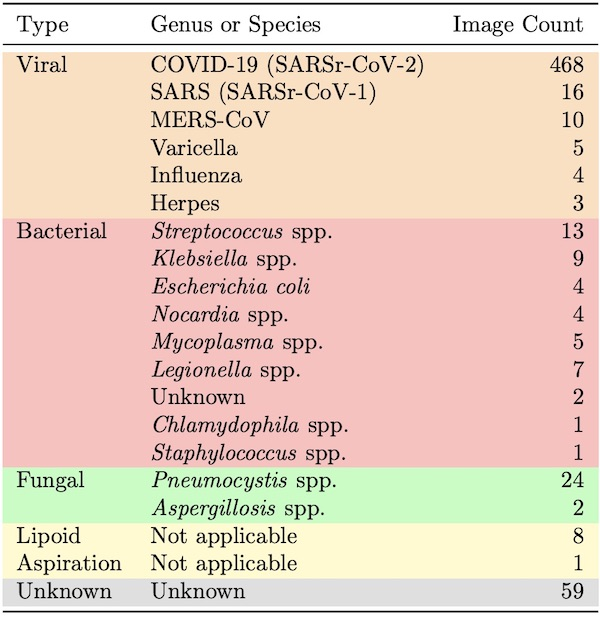

The data was encoded into two categories: 'positive' for those patients that tested positive in Covid-19 and 'negative' for those who tested negative in Covid-19 regardless of having any other lung condition or not.

In [1]:
# For deeplearning
import tensorflow as tf       
from tensorflow import keras 
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
# For managing files   
import os
# For image manipulation
from PIL import Image
import cv2
import imutils
# Vectorized code, translate images into vector arrays
import numpy as np
# Data processing, confusion matrix and classification report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
# For visualization and image display
import matplotlib.pyplot as plt
import cv2
import imutils
from google.colab.patches import cv2_imshow
# Utilities
from collections import Counter
import copy
import random

## 1 Defining functions

These are the functions we will be using for the rest of the project.

In order to load the data **it was necessary to pseudo-colorize the images so it could be used with transfer learning** (most of them only accept images with RGB channels), there were several trials with other models to train a grayscale image classifier, but none of them got past the 76% in the test set. **Colorizing the images highly improved the models performance.**

In [27]:
def dict_labels(path):
    '''This function takes a path to the file with the labels and returns a 
    dictionary with the name of the picture and the labels'''

    with open(path) as f:
        lines = f.readlines()
    split_lines = [line.split() for line in lines]

    return {split_line[1]:split_line[2] for split_line in split_lines}


def load_colorize_images(path, path_doc, image_size=(112,112)): 
    '''This function accepts a path to the images, a path to the document with
    the labels and image size (112x112 by default), it pseudo-colorizes the 
    images and returns two arrays: one with the pseudo-colorized images and 
    another one with the output labels'''

    data = []
    titles = []

    for file in os.listdir(path):
        path_file = path + '/' + file
        img = cv2.imread(path_file,0)
        img = cv2.resize(img, image_size)
        img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
        img = (img/255).astype(np.float32)
        data.append(img)
        titles.append(file) 

    dict_data_labels = dict_labels(path_doc)

    return np.array(data), np.array([dict_data_labels[title] 
                                     for title in titles])
    
    
def visualize_imgs(X, y, label, normalized):
    '''This function accepts the data (X), labels (y), a label condition that 
    can be either 'positive' or 'negative' (label) and whether the image has 
    been normalized or not (normalized), it's necessary to explicitly say it has 
    been normalized typing 'yes', any other input would be considered as 'no'. 
    It returns 4 images'''

    fig = plt.figure(figsize=(18, 18))
    columns = 4
    rows = 1
    X_filt = X[y == label]
    y_filt = y[y == label]

    for i in range(1, columns*rows + 1):
        img = X_filt[i,:,:]
        lb = y_filt[i]
        fig.add_subplot(rows, columns, i)
        if normalized == 'yes':
            plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        plt.title(lb)
        plt.axis('off')
    plt.show()


def to_onehot_categorical(y, class_names):
    '''This function accepts the categories from the output (y), and the 
    category names (class_names), and returns the output in one hot encoding'''

    label_encoder = LabelEncoder() 
    vec_y = label_encoder.fit_transform(y)      
    return to_categorical(vec_y, num_classes=len(class_names))   


def label_translator(class_names, y_pred):
    '''This function accepts a list with the original name of the classes 
    (class_names) and the predicted results (y_pred), returning 
    a list of the predicted results translated into the original class names'''

    y_copy = copy.deepcopy(y_pred)

    masked = []
    for prediction in y_copy:
        prediction[np.argmax(prediction)] = 1
        masked.append((prediction >= 1).astype('int32'))

    class_names_hot = to_onehot_categorical(class_names, class_names)

    stringed_hot = [str(onehot.astype('int32')) for onehot in class_names_hot]
    labels_dict = dict(zip(stringed_hot, class_names))
     
    return [labels_dict[str(array)] for array in masked]


def confusion_matrix_plot(y_test, y_pred, class_names):
    '''This function accepts the actual labels of the test, the predicted labels
    and the original name of the labels. It returns a plot with the confusion
    matrix'''

    y_test_predicted = label_translator(class_names, y_pred)
    conf_matrix = confusion_matrix(y_test, y_test_predicted)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', 
                    size='xx-large')
    
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.title('Confusion Matrix\n\n', fontsize=14)
    plt.show()


def random_positive():
    '''This function generates a path to a random file that has been correctly
    classified as positive by the model, and its index'''

    files = [path_test + '/' + file for file in os.listdir(path_test)]

    indexes = [index for index, element in enumerate(y_test_predicted) if 
               element == 'positive' and y_test[index] == 'positive']

    image_index = random.choice(indexes)

    return files[image_index], image_index

## 2. Data Preparation

In [4]:
path_train = '/content/drive/MyDrive/Deep Learning Datasets/covid_xray/train'
path_test = '/content/drive/MyDrive/Deep Learning Datasets/covid_xray/test'
path_doc_train = '/content/drive/MyDrive/Deep Learning Datasets/covid_xray/train.txt'
path_doc_test = '/content/drive/MyDrive/Deep Learning Datasets/covid_xray/test.txt'

In [ ]:
color_data, y = load_colorize_images(path_train, path_doc_train)

In [7]:
# np.save('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/color_data.npy', color_data)
# np.save('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/y.npy', y)
color_data = np.load('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/color_data.npy')
y = np.load('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/y.npy')

Visualization of several examples that tested positive and negative Covid-19:

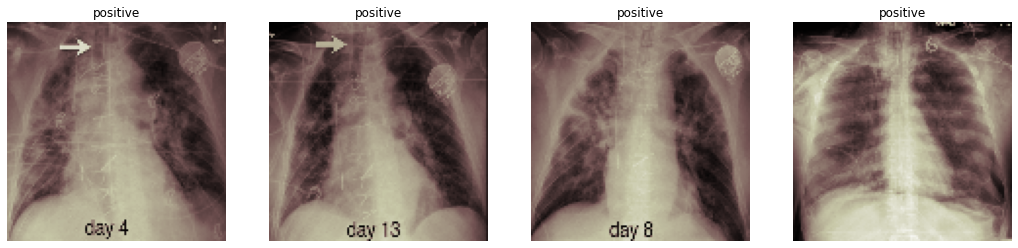

In [ ]:
visualize_imgs(color_data, y, label='positive', normalized='yes')

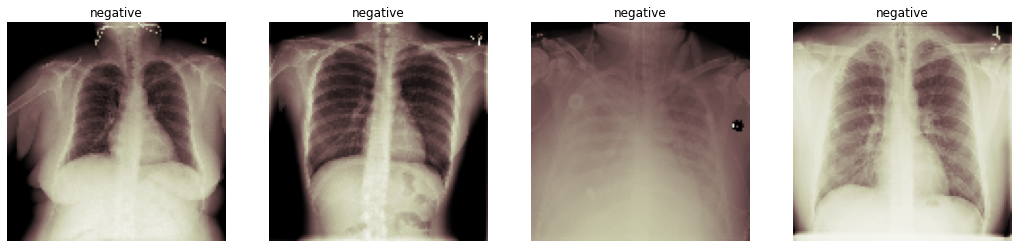

In [ ]:
visualize_imgs(color_data, y, label='negative', normalized='yes')

In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(color_data, y, 
                                                                test_size=0.2, 
                                                                random_state=42)

In [9]:
# Establishing class names and number of classes

classes = len(np.unique(y_train))
class_names  = sorted(list(set(y_train)))
print(class_names)

['negative', 'positive']


In [10]:
del color_data 

In [ ]:
X_test, y_test = load_colorize_images(path_test, path_doc_test)

In [11]:
# np.save('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/X_test.npy', X_test)
# np.save('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/y_test.npy', y_test)
X_test = np.load('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/X_test.npy')
y_test = np.load('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/y_test.npy')

In [12]:
# Using one hot encoded labels to train our model

y_train_hot = to_onehot_categorical(y_train, class_names)
y_validation_hot = to_onehot_categorical(y_validation, class_names)
y_test_hot = to_onehot_categorical(y_test, class_names)

We have a total of 16,351 radiography split into training, validation and test sets.

The data is asymmetrical with more 'negative' radiography than 'positive' (see below)

In [8]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)
print(Counter(y_train))
print(Counter(y_validation))
print(Counter(y_test))

(12760, 112, 112, 3)
(3191, 112, 112, 3)
(400, 112, 112, 3)
Counter({'negative': 11040, 'positive': 1720})
Counter({'negative': 2753, 'positive': 438})
Counter({'negative': 200, 'positive': 200})


## 3. Modeling

After several experiments, we reached several conclusions:

* The convolutional neural network architecture that always perfomed the best was **Xception**, an architecture based on Inception developed by Google researchers.
* **Data augmentation doesn't work well with radiography**, it only make the model better in the case of ResNet50 and it only improved by 0.25 percentage points. Several types of data augmentation were tried and the ones that did better were those which changes were more subtle.

For the modeling we used an early stopping monitoring the validation loss with patience of 5. This combined well with a learning rate reducer with patience of 2, also monitoring validation loss and with a factor of 1/10. 

The other models performed like this in the test set: 
* **LeNet5/AlexNet inspired** own model with **grayscale images**: 76%
* **LeNet5/AlexNet inspired** own model with **colored images**: 85.3%
* **ResNet50** (trainable weights and data augmentation): 89% 
* **VGG16** (with frozen weights): 92% 
* **Xception** (trainable weights): 95.25%

It is worh mentioning that the model that presented less overfitting was the Xception, the rest of the models performed much better in the training and validation sets than in the test set, not being suitable for generalization.

The initial intention was creating an ensemble using the best models, but given that there was a big difference between models performance and that all of them tended to overstimate the 'negatives' (it could be an effect of the asymmetrical nature of our data), we decided not to use an ensemble.

In [ ]:
batch_size = 32

steps_per_epoch = X_train.shape[0] // batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 monitor='val_loss', 
                                                 mode='min')

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                  factor=0.1, patience=2, 
                                                  min_lr=0.0000001)

### 3.1. Transfer Learning Model (Xception)

The Xception architecture is inspired by the Inception archictecture in which its modules output the combination (concatenated) of several convolutions with different filters and a pooling layer, this has a high computational cost. 

The Xception architecture on the other hand, substitutes these Inception modules for a much lighter depthwise separable convolution. 
(Link to the original paper: https://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf)

For a better performance, we trained the Xception model **setting all parameters as trainable**. For the top part we used a 3 dense layer with a **sigmoid** as the last activation function and a **binary crossentropy** as the loss function, given that we are trying to solve a binary classification problem: those radiography that are 'positive' and those that are 'negative'.

We used the Google Colab GPU in order to train the model.

In [ ]:
xception = tf.keras.applications.xception.Xception(include_top=False, 
                                                   weights='imagenet', 
                                                   input_shape=[112,112,3])

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
xception.trainable = True

In [ ]:
# Creating our own top part

x = keras.layers.Flatten()(xception.output)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(classes, activation='sigmoid')(x)

In [ ]:
# Joining both parts

model_xception = tf.keras.models.Model(inputs=xception.input, outputs=x)

In [ ]:
model_xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 55, 55, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 55, 55, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 55, 55, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
model_xception.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
model_xception.fit(X_train, y_train_hot, steps_per_epoch=steps_per_epoch, 
                   epochs=15, validation_data=(X_validation, y_validation_hot), 
                   callbacks=[lr_reducer, earlystopping])

Epoch 1/15
398/398 [==============================] - 67s 117ms/step - loss: 0.1938 - accuracy: 0.9246 - val_loss: 0.7380 - val_accuracy: 0.6227
Epoch 2/15
398/398 [==============================] - 45s 114ms/step - loss: 0.0951 - accuracy: 0.9688 - val_loss: 0.1384 - val_accuracy: 0.9561
Epoch 3/15
398/398 [==============================] - 45s 114ms/step - loss: 0.0597 - accuracy: 0.9801 - val_loss: 0.2744 - val_accuracy: 0.9361
Epoch 4/15
398/398 [==============================] - 45s 114ms/step - loss: 0.0524 - accuracy: 0.9833 - val_loss: 0.1038 - val_accuracy: 0.9662
Epoch 5/15
398/398 [==============================] - 45s 114ms/step - loss: 0.0349 - accuracy: 0.9873 - val_loss: 0.4637 - val_accuracy: 0.9662
Epoch 6/15
398/398 [==============================] - 45s 114ms/step - loss: 0.0293 - accuracy: 0.9896 - val_loss: 0.0932 - val_accuracy: 0.9771
Epoch 7/15
398/398 [==============================] - 45s 114ms/step - loss: 0.0707 - accuracy: 0.9752 - val_loss: 0.1049 - val_ac

#### 3.1.1 Analyzing results

We have a model that performs with an accuracy of the **99.98% in the training set**, **98.4% in the validation set** and a **95.25% in the test set**. 

It has a **precision of 100%** when it comes to detecting the positive cases which means that it never classifies mistakes a negative for a positive, but on the other hand it has a **recall of 91% for positive cases**, this means that the model tends to predict some negative results as positive.

In [ ]:
model_xception.evaluate(X_test, y_test_hot)

13/13 [==============================] - 0s 35ms/step - loss: 0.2593 - accuracy: 0.9525


[0.25927263498306274, 0.9524999856948853]

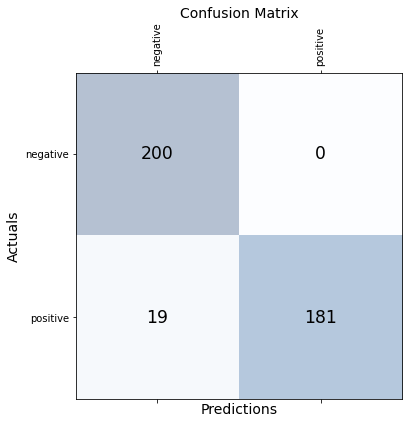

In [14]:
y_pred = model_xception.predict(X_test)
confusion_matrix_plot(y_test, y_pred, class_names)

In [15]:
y_test_predicted = label_translator(class_names, y_pred)
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

    negative       0.91      1.00      0.95       200
    positive       1.00      0.91      0.95       200

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400



In [13]:
# model_xception.save('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/model_xception.h5')
model_xception = keras.models.load_model('/content/drive/MyDrive/Deep Learning Datasets/covid_xray/model_xception.h5')

## 4. Class Activation Visualization

We managed to create a model that accurately predicts the class of each radiography, now we will try localize where our Convolutional Neural Network detected the differences between one class (positive) and the other (negative).

For that we need to create a Class Activation Visualization with the weights of our convolutional network using the last convolutional layer as reference, to create a heatmap that will be overlayed on the radiography. 

In order to do this, I used the functions given in this github repository: https://github.com/wiqaaas/youtube/tree/master/Deep_Learning_Using_Tensorflow/Demystifying_CNN

We had to change the code in order to suit our needs, as we used a custom Xception model and our images were processed differently.

In [16]:
class GradCAM:
  
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs], 
                          outputs= [self.model.get_layer(self.layerName).output, 
                                    self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [18]:
# Randomly selects a correctly classified positive image 

image_path, image_index = random_positive()

In [19]:
# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions

orig = cv2.imread(image_path)
orig = cv2.applyColorMap(orig, cv2.COLORMAP_BONE)
resized = cv2.resize(orig, (224, 224))

In [20]:
# load the input image from memory (in Keras/TensorFlow format) and
# preprocess it

image = load_img(image_path, target_size=(112, 112))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
preprocess_input = tf.keras.applications.xception.preprocess_input
image = preprocess_input(image)

In [21]:
# Gets the class

model = model_xception
preds = model.predict(image)
i = np.argmax(preds[0])

In [22]:
# Initialize our gradient class activation map and build the heatmap

cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

In [23]:
# resize the resulting heatmap to the original input image dimensions
# and overlays it

heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

positive


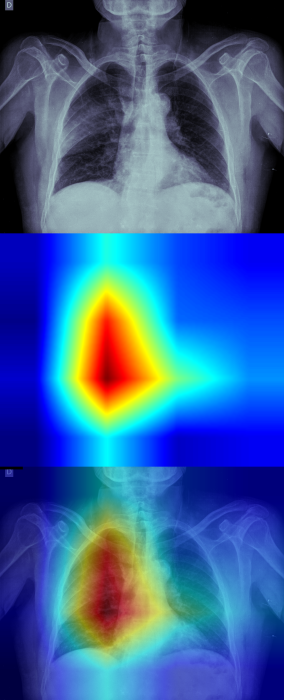

In [84]:
# display the original image and resulting heatmap and output image

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
print(y_test_predicted[image_index])
cv2_imshow(output)
cv2.waitKey(0)
cv2.destroyAllWindows()